In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import librosa

from tqdm import tqdm_notebook as tqdm

from recording import Recording
from auxiliary import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font='serif')

import os,string

from collections import Counter

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
dh = DataHandler()

In [3]:
df = dh.build_feature_data(condition=2)

KeyboardInterrupt: 

In [83]:
valid_phonemes = list(''.join([string.ascii_letters,string.digits,'@']))
df = df[df.phoneme.isin(valid_phonemes)]
common_phonemes = {phoneme: count for phoneme,count in Counter(df.phoneme).most_common(48)}
common_phonemes

{'I': 1644,
 'n': 1548,
 'a': 1488,
 't': 1271,
 'm': 913,
 's': 865,
 'd': 770,
 'v': 638,
 'i': 530,
 'g': 486,
 'b': 475,
 'l': 441,
 'e': 437,
 'N': 405,
 'z': 397,
 '@': 378,
 'tasp': 358,
 'U': 323,
 'E': 312,
 'p': 305,
 'f': 301,
 'S': 288,
 'k': 285,
 '6': 259,
 'x': 241,
 'C': 216,
 'aI': 209,
 'o': 204,
 '_d': 200,
 'O': 181,
 '4': 176,
 'kasp': 173,
 'pasp': 158,
 'dasp': 153,
 'X': 149,
 'Y': 109,
 'aU': 101,
 'j': 88,
 'i6': 84,
 'B': 84,
 'V': 83,
 '?': 76,
 'gef': 71,
 'gasp': 69,
 '9': 57,
 'y': 55,
 'D': 53,
 'u': 52}

In [76]:
X = np.squeeze(np.stack(df.feature_vec.tolist()))
y = df.phoneme.tolist()
X.shape

(18576, 62)

In [77]:
X_scl = StandardScaler().fit_transform(X)

In [80]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scl)
np.cumsum(pca.explained_variance_ratio_)

array([0.08298785, 0.14783619, 0.20197189, 0.24253626, 0.27946042,
       0.31150672, 0.3427967 , 0.37207689, 0.40063944, 0.42717662,
       0.45225006, 0.47619773, 0.49885929, 0.52062694, 0.54150069,
       0.56169527, 0.5805919 , 0.59904602, 0.61651089, 0.63361638,
       0.65037683, 0.66634826, 0.68177627, 0.69693736, 0.71186837,
       0.72613816, 0.74029893, 0.75393555, 0.76711256, 0.77977986,
       0.792298  , 0.80448907, 0.81653321, 0.82785073, 0.83848273,
       0.84897482, 0.85916838, 0.86891523, 0.87856645, 0.88795625,
       0.89693613, 0.90566985, 0.91370988, 0.92136318, 0.92886851])

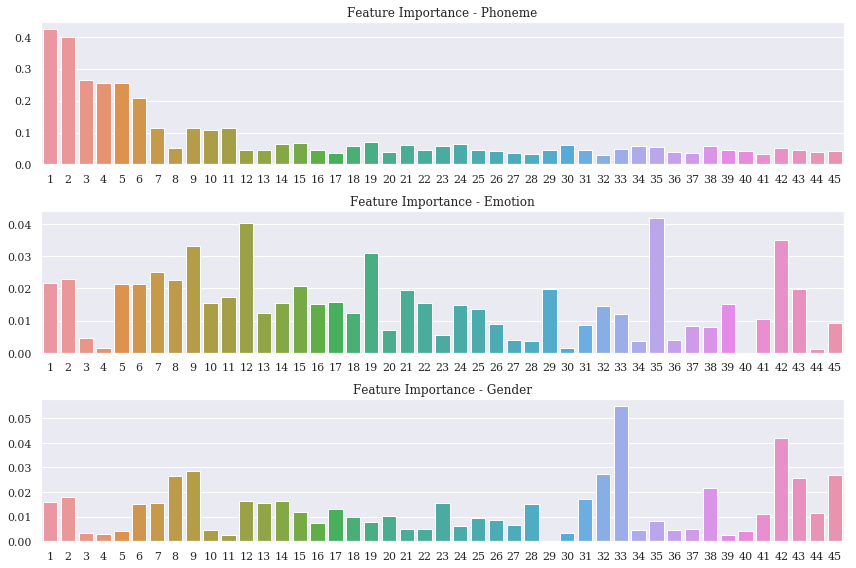

In [81]:
fig, ax = plt.subplots(nrows=3,figsize=(12,8))

X_imp = X_pca

feature_score = mutual_info_classif(X_imp,df.phoneme.tolist())
sns.barplot(x=[i+1 for i in range(len(feature_score))],y=feature_score,ax=ax[0])
ax[0].set_title('Feature Importance - Phoneme')

feature_score = mutual_info_classif(X_imp,df.emotion_name.tolist())
sns.barplot(x=[i+1 for i in range(len(feature_score))],y=feature_score,ax=ax[1])
ax[1].set_title('Feature Importance - Emotion')

feature_score = mutual_info_classif(X_imp,df.speaker_id.tolist())
sns.barplot(x=[i+1 for i in range(len(feature_score))],y=feature_score,ax=ax[2])
ax[2].set_title('Feature Importance - Gender')

plt.tight_layout()

In [82]:
tsne = TSNE(verbose=1)
transformed = tsne.fit_transform(X_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18576 samples in 0.040s...
[t-SNE] Computed neighbors for 18576 samples in 34.765s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18576
[t-SNE] Computed conditional probabilities for sample 2000 / 18576
[t-SNE] Computed conditional probabilities for sample 3000 / 18576
[t-SNE] Computed conditional probabilities for sample 4000 / 18576
[t-SNE] Computed conditional probabilities for sample 5000 / 18576
[t-SNE] Computed conditional probabilities for sample 6000 / 18576
[t-SNE] Computed conditional probabilities for sample 7000 / 18576
[t-SNE] Computed conditional probabilities for sample 8000 / 18576
[t-SNE] Computed conditional probabilities for sample 9000 / 18576
[t-SNE] Computed conditional probabilities for sample 10000 / 18576
[t-SNE] Computed conditional probabilities for sample 11000 / 18576
[t-SNE] Computed conditional probabilities for sample 12000 / 18576
[t-SNE] Computed conditional probabilities for sa

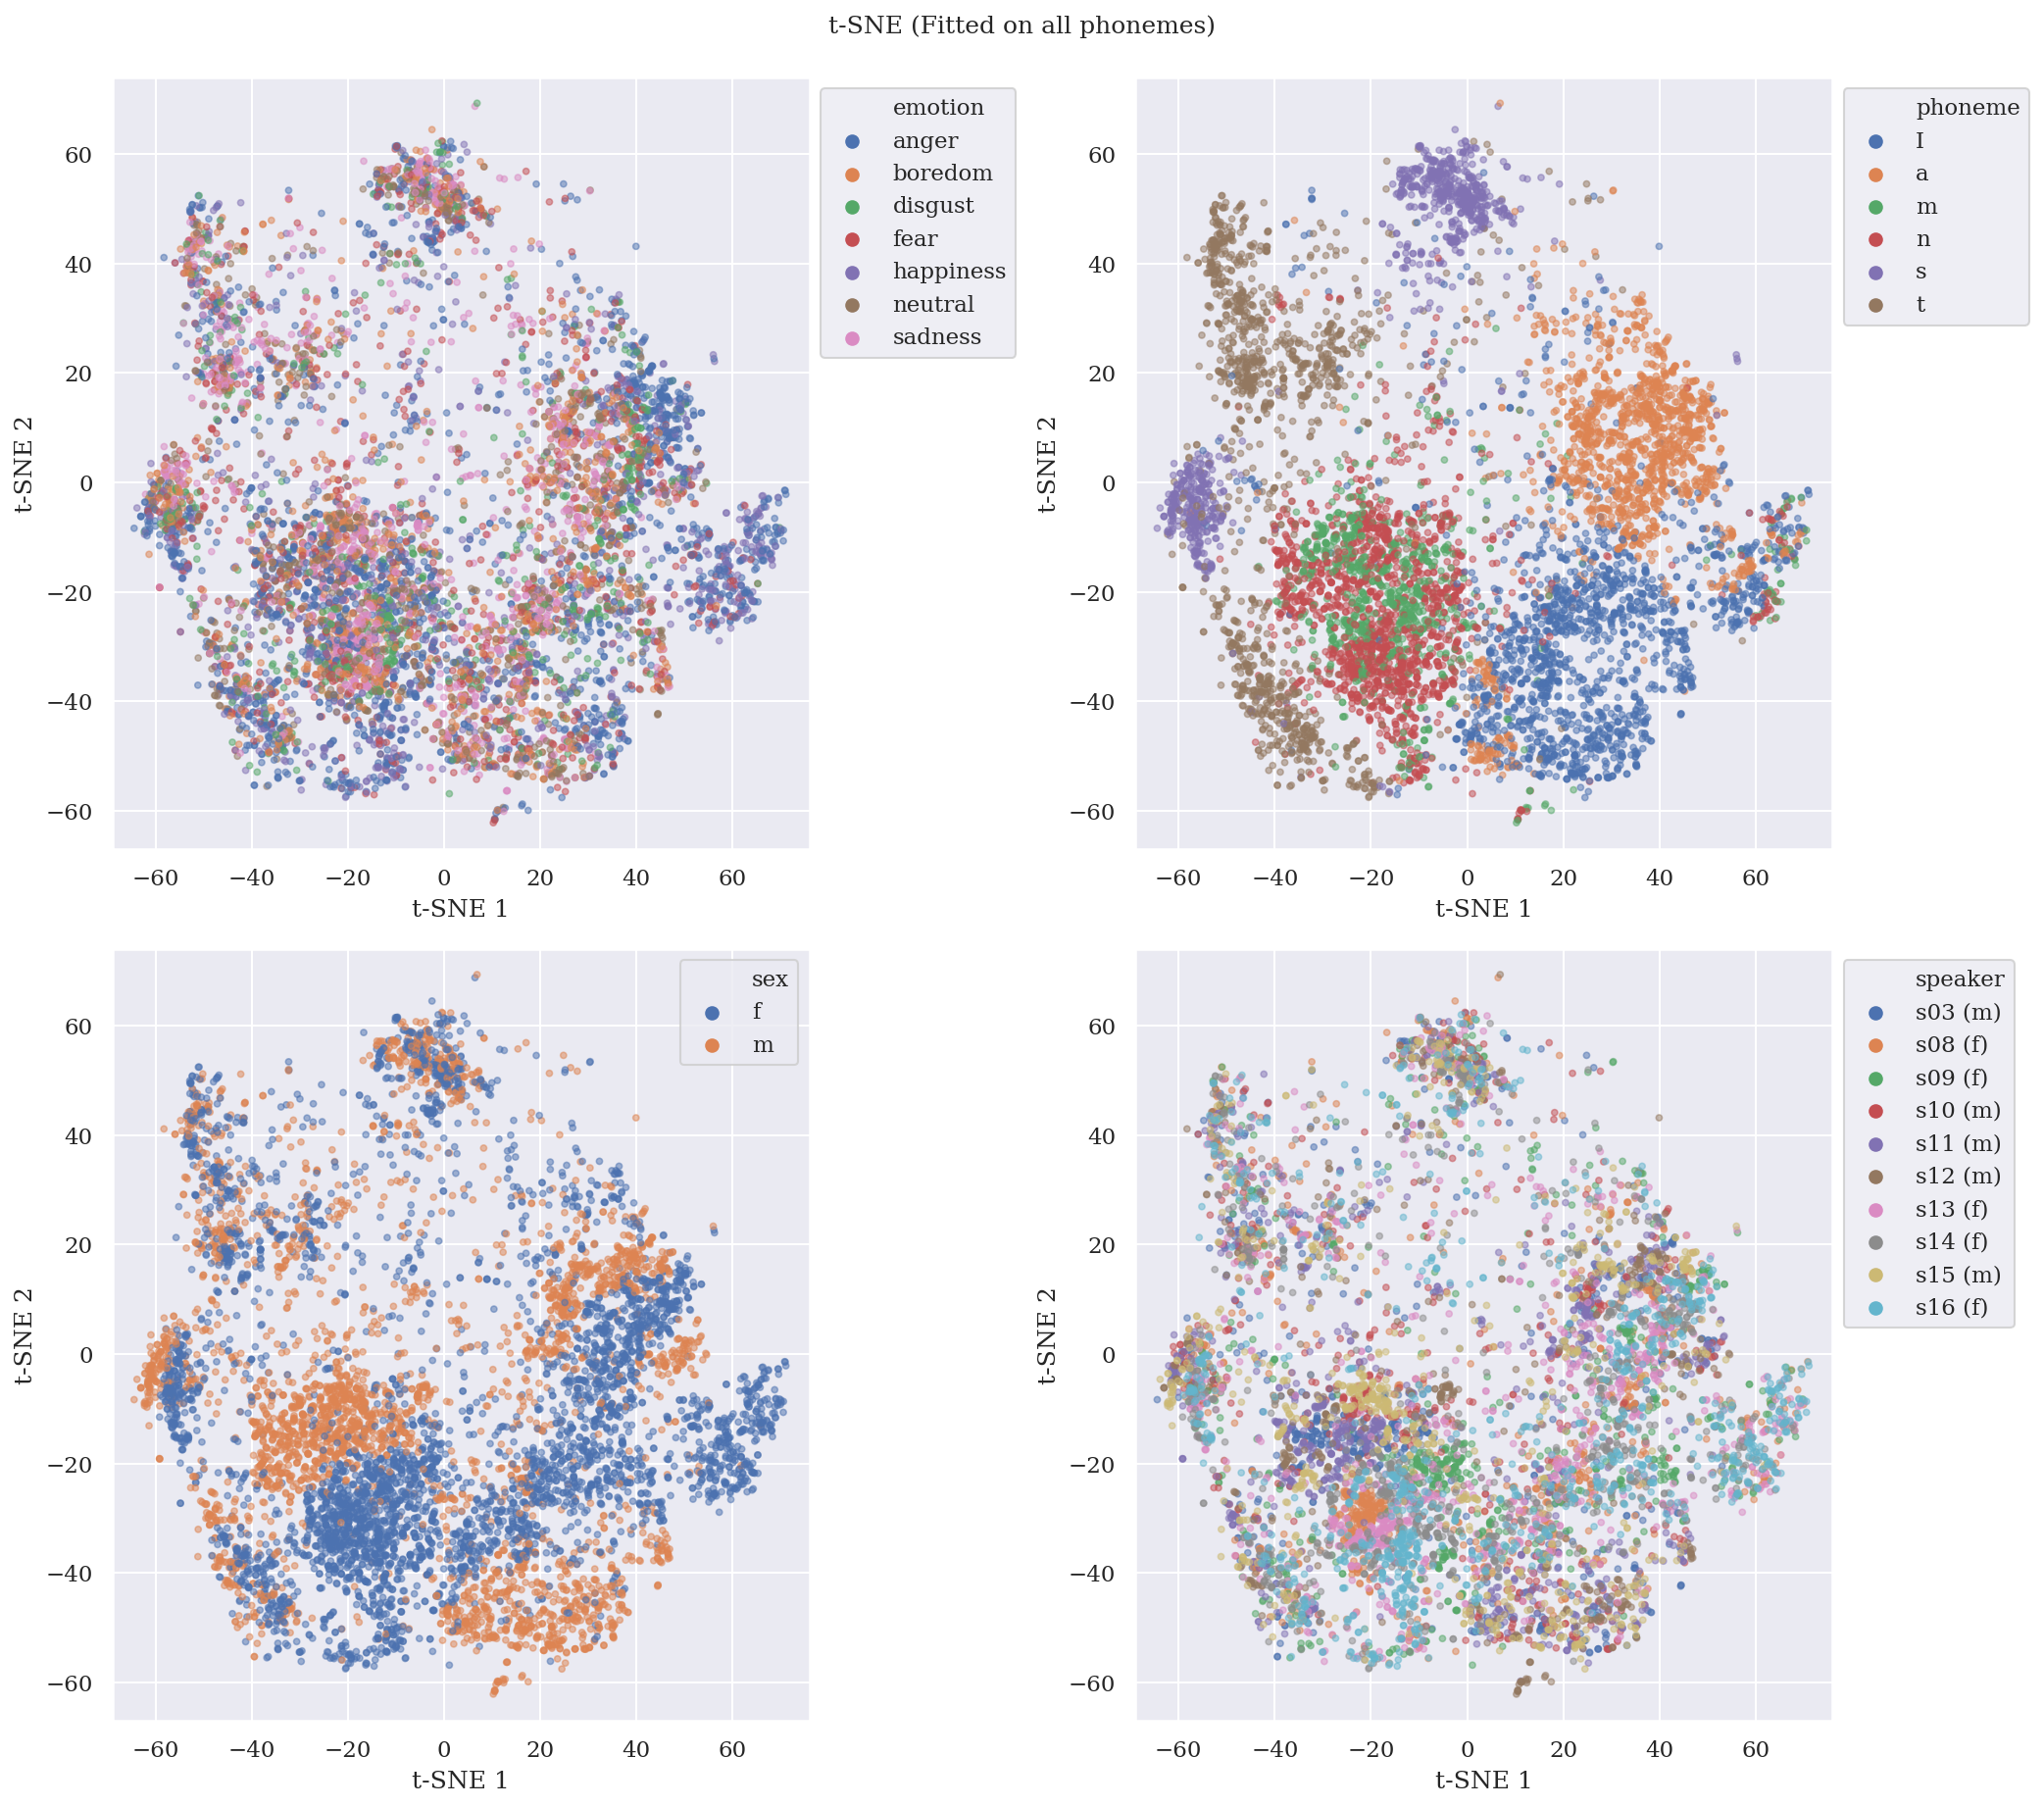

In [85]:
plot_df = pd.DataFrame({'t-SNE 1': transformed[:,0],
                        't-SNE 2': transformed[:,1],
                        'phoneme': df.phoneme.tolist(), 
                        'emotion': df.emotion_name.tolist(),
                        'speaker': ['s%s (%s)'%(row.speaker_id,row.sex) for i,row in df.iterrows()],
                        'sex': df.sex.tolist(),
                        'pitch': [row.feature_vec[-2] for i,row in df.iterrows()]})

def plot_tSNE_by_hue(data,hue,ax):
    sns.scatterplot('t-SNE 1',
                    't-SNE 2',
                    data=data,
                    hue=hue,
                    hue_order=sorted(set(data[hue])),
                    marker='.',
                    edgecolor=None,
                    alpha=.5,
                    ax=ax)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlim([int(min(data['t-SNE 1'])-5),int(max(data['t-SNE 1']))+5])
    ax.set_ylim([int(min(data['t-SNE 2'])-5),int(max(data['t-SNE 2']))+5])
    
def visualize_tSNE(data,title):
    fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(14,12),dpi=150)
    fig.suptitle(title,y=1.02)
    plot_tSNE_by_hue(data,hue='emotion',ax=ax[0][0])
    plot_tSNE_by_hue(data,hue='phoneme',ax=ax[0][1])
    plot_tSNE_by_hue(data,hue='sex',ax=ax[1][0])
    plot_tSNE_by_hue(data,hue='speaker',ax=ax[1][1])
    plt.tight_layout()

phoneme_list = list(common_phonemes.keys())[:6]
visualize_tSNE(plot_df[plot_df.phoneme.isin(phoneme_list)],title='t-SNE (Fitted on all phonemes)')